### Trading pairs
Trading pairs is a simple statistical arbitrage strategy that creates a market-neutral portfolio and tries to exploit market inefficieny in two highly correlated assets. The idea is to short one of the assets if it is overvalued relative to the second asset and simultaneously enter a long position in the other asset.

In [2]:
import sys
sys.path.append("../TradingSystem") # go to parent dir

In [1]:
# Ignore panda warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import yfinance as yf
import numpy as np

In [3]:
# Download financial data for a variety of
# cryptocurrencies and banks

crypto = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'ADA-USD', 'BSV-USD','DASH-USD']
bank = ['JPM', 'BAC', 'WFC', 'C', 'GS', 'MS', 'DB']
tickers = crypto + bank
startDate = '2021-01-01'
endDate = '2023-10-31'

dataMap = {}
for ticker in tickers:
    dataMap[ticker]= yf.download(ticker, start=startDate, end=endDate, progress = False)

In [13]:
 #Clean the data
totalTime = (pd.to_datetime(endDate) -
                      pd.to_datetime(startDate)).days
cleanData = {}
validTickers = []
dateRange = pd.date_range(start=startDate, end=endDate, freq='D')
for ticker in dataMap:


    if dataMap[ticker] is None or len(dataMap[ticker]) < (totalTime / 2):
        continue
    df = dataMap[ticker][['Adj Close']]
    df =df [-totalTime:]
        # Reindex the time series to match the date range and fill in any blanks (Not Numbers)
    df = df.reindex(dateRange)
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.interpolate(method='linear')
    df['Adj Close'].fillna(method='pad', inplace=True)
    df['Adj Close'].fillna(method='bfill', inplace=True)
    assert not np.any(np.isnan(df['Adj Close'])) and not np.any(np.isinf(df['Adj Close']))
    cleanData[ticker] = df
    validTickers.append(ticker)
    
    
   



### Cointegration
Let $X_t$ be a stochastic process and $F_X(x_1,\ldots,x_n)$ be the cumulative distribution function. The process is called {\em stationary} if 
\begin{equation}
    F_X(x_{t_1+\tau},\ldots, x_{t_n+\tau}) =  F_X(x_{t_1},\ldots, x_{t_n}) \forall t_1,\ldots,t_n,\tau ,n.
\end{equation}
For a stationary the mean $E(X_t)=\mu$ is time-independent.
(Connection to dynamical systems: Stationary processes are closely related to being measure preserving for the shift map. See http://galton.uchicago.edu/~lalley/Courses/381/ErgodicTheorem.pdf for a dicussion. )
One can then similarly define ergodic stochastic processes. We will not do this here but instead note that if a process is ergodic and stationary, then 
\begin{equation}
\dfrac{1}{T}\int_{i=1}^n X_t(\omega) = \mu.
\end{equation}
(A restatement of Birkhoffs ergodic theorem: Time-average equals space-average)

In particular, ergodic and stationary processes are mean-reverting, i.e. the time series eventually returns to the mean.

### Testing for cointegration

For our trading of pair strategy we will assume an autogregressive-model $AR(p)$ for $X_t$ , i.e.
\begin{equation}
   y_t = \alpha_1+\alpha_2t +\sum_{i=1}^p \beta_i y_{t-i}+\epsilon_t.
\end{equation}
By taking successive differences this can be written as 

\begin{equation}
    \Delta y_t = \alpha_1+\alpha_2t +\gamma \Delta y_{t-1}+\sum_{i=1}^p \beta_i \Delta y_{t-i}+\epsilon_t,
\end{equation}
where $\Delta y_k = y_k - y_{k-1}$.

One can show that an $AR(p)$ model is ergodic and stationary if and only if it has no root of unity, i.e. $\gamma=0$.
The Augmented Dickey-Fuller(ADF) test is a hypothesis test with
$H_0: \gamma=0.$


To test two time seris $x_t, y_t$ for cointegration we use the Engle and Granger 2-step approach. 
 - Test that $x_t$ and $y_t$ are non-stationary using the ADF test.
 - Regress $y_t$ on $x_t$ and use a $t$-test to tset for cointegration.



In [14]:
from statsmodels.tsa.stattools import coint
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from itertools import combinations


# Compute p values for the Engle-Granger test

n = len(tickers)

pThreshold = 0.02
# Extract 'Adj Close' prices into a matrix (each column is a time series)
adjCloseMatrix = np.column_stack(
    [cleanData[ticker]['Adj Close'].values for ticker in validTickers])
pValMatrix = np.ones((n, n))
# Calculate cointegration p-values for unique pair combinations
for i, j in combinations(range(n), 2):
    result = coint(adjCloseMatrix[:, i], adjCloseMatrix[:, j])
    pValMatrix[i, j] = result[1]
pairs = [(tickers[i], tickers[j], pValMatrix[i, j])
            for i, j in zip(*np.where(pValMatrix < pThreshold))]



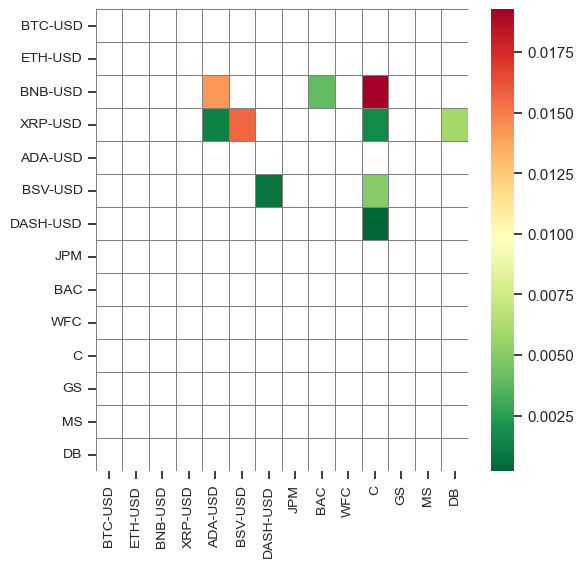

In [26]:

# Draw a heatmap showing all pairs whose time series is cointegrated and if so, how small the p-Value is
plt.figure(figsize=(6, 6))
heatmap = sns.heatmap(pValMatrix, xticklabels=cleanData.keys(),
                      yticklabels=cleanData.keys(), cmap='RdYlGn_r',
                      mask=(pValMatrix > (pThreshold)),
                      linecolor='gray', linewidths=0.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), size=10)
heatmap.set_yticklabels(heatmap.get_yticklabels(), size=10)
plt.show()

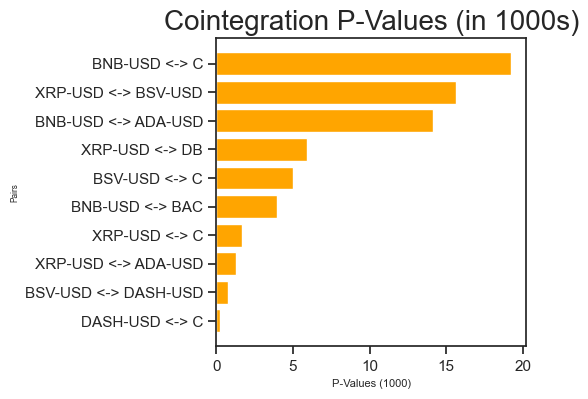

In [23]:
# Choose pairs with largest p values

sortedPairs = sorted(pairs, key=lambda x: x[2], reverse=False)
sortedPairsLabels, pairPValues = zip(
    *[(f'{y1} <-> {y2}', p*1000) for y1, y2, p in sortedPairs])
sns.set_style('ticks')
plt.figure(figsize=(4, 4))
plt.barh(sortedPairsLabels,
         pairPValues, color='orange')
plt.xlabel('P-Values (1000)', fontsize=8)
plt.ylabel('Pairs', fontsize=6)
plt.title('Cointegration P-Values (in 1000s)', fontsize=20)
# plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

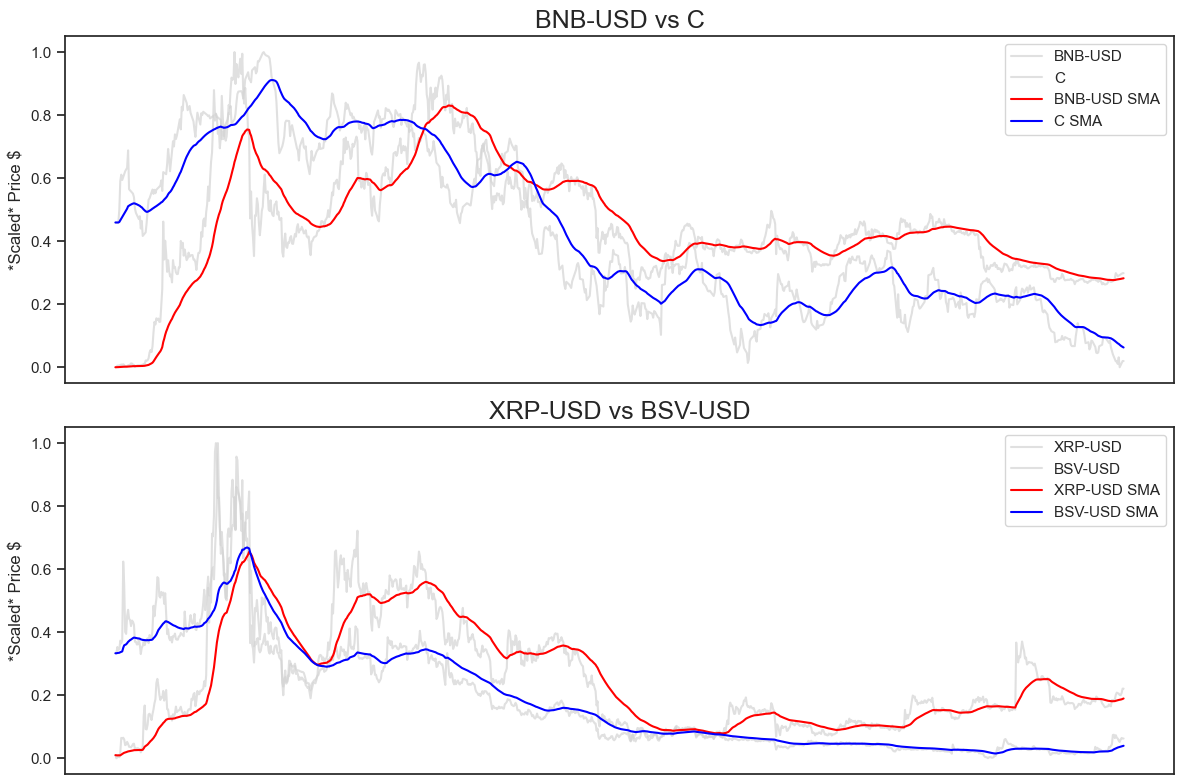

In [27]:
from sklearn.preprocessing import MinMaxScaler

tickerPairs = [("BNB-USD", "C"), ("XRP-USD", "BSV-USD")]
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
scaler = MinMaxScaler()
for i, (ticker1, ticker2) in enumerate(tickerPairs):
    # Scale the price data for each pair using MIN MAX
    scaledData1 = scaler.fit_transform(
        cleanData[ticker1]['Adj Close'].values.reshape(-1, 1))
    scaledData2 = scaler.fit_transform(
        cleanData[ticker2]['Adj Close'].values.reshape(-1, 1))
    axs[i].plot(scaledData1, label=f'{ticker1}', color='lightgray', alpha=0.7)
    axs[i].plot(scaledData2, label=f'{ticker2}', color='lightgray', alpha=0.7)


    # Compute exponential moving average with alpha = 0.04
    smoothData1 = pd.Series(scaledData1.reshape(-1)).ewm(alpha=0.04, adjust=False).mean()
    smoothData2 = pd.Series(scaledData2.reshape(-1)).ewm(alpha=0.04, adjust=False).mean()


    axs[i].plot(smoothData1, label=f'{ticker1} SMA', color='red')
    axs[i].plot(smoothData2, label=f'{ticker2} SMA', color='blue')
    axs[i].set_ylabel('*Scaled* Price $', fontsize=12)
    axs[i].set_title(f'{ticker1} vs {ticker2}', fontsize=18)
    axs[i].legend()
    axs[i].set_xticks([])
plt.tight_layout()
plt.show()

In [18]:
from TradingSystem import *
from Strategy import Strategy

class PairTradingStrategy(Strategy):


    def __init__(self,ticker1,ticker2, cleanData):
        super().__init__()
        
        self.ticker1 = ticker1
        self.ticker2 = ticker2
        self.cleanData = cleanData
       

        

    def OnBar(self, verbose = False):
        scaledData1 = self.cleanData[self.ticker1]['Adj Close'].values.reshape(-1) 
        scaledData2 = self.cleanData[self.ticker2]['Adj Close'].values.reshape(-1) 
        ratios = scaledData1 / scaledData2
        ratiosMean = pd.Series(ratios).ewm(alpha=0.04, adjust = False).mean()
        ratiosStd = pd.Series(ratios).ewm(alpha=0.04, adjust = False).std()
        
        # Compute the z scores and test if the deviation from the mean
        # is more than one standard deviation
        # If yes, then buy
        self.zScores = (ratios - ratiosMean) / ratiosStd
        
        ts = self.cleanData[self.ticker1].index.get_loc(self.current_idx)
        zScore = self.zScores[ts]



        
        if zScore >1:
            self.Buy(self.ticker2, size = 1)
            self.Sell(self.ticker1, size = ratios[ts])
            
        else:
            self.Buy(self.ticker1, size = ratios[ts])
            self.Sell(self.ticker2, size = 1)


  0%|          | 0/711 [00:00<?, ?it/s]

100%|██████████| 711/711 [00:00<00:00, 1932.27it/s]


Starting Portfolio Value: 10000.00
Final Portfolio Value: 11954.10
{'Total Return': 19.54099441502457, 'Volatility': 0.20081118140940554, 'Average Return': 0.3260107577493408, 'Riskfree Return': 0.02857308213801898, 'Sharpe': 1.4811808462244849}


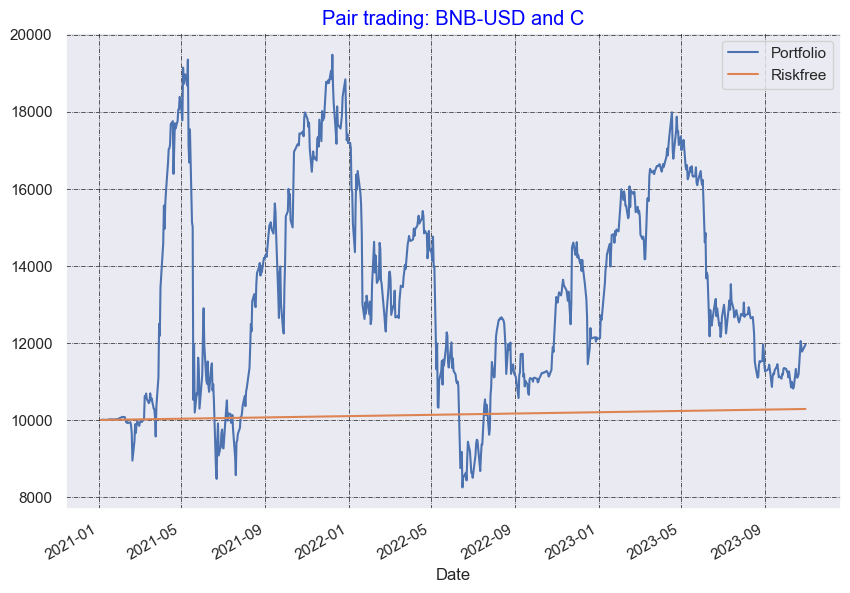

In [19]:
tickers= ["BNB-USD", "C"]





# Initialize the trading system
trader = TradingSystem()
# Add the Apple data to the trading system
for ticker in tickers:
    trader.AddCleanData(ticker, dataMap[ticker])
# Set the strategy of the trading system to a naive strategy
# where we buy on one day and sell on the next day
trader.SetStrategy(PairTradingStrategy(tickers[0], tickers[1],cleanData))
# The portfolio starts with $10000 
trader.portfolio.SetInitialCash(10000)


 
 # Perform a backtest for the basic trading strategy  
trader.Run()




print('Starting Portfolio Value: %.2f' % trader.portfolio.initialCash)
print('Final Portfolio Value: %.2f' % trader.GetPortfolioValue())
# PlotStockData(ticker, (trader.datas[ticker])['Adj Close'])


# Analyze the backtest by providing various statistics
print(trader.GetStats())
pairLog = trader.log['Portfolio']
trader.log.plot(figsize=(10,7))
plt.title("Pair trading: BNB-USD and C",size='large',color='blue')
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

The pair strategy beats the risk-free rate (which we set to 1%). Next we compare it to the S&P 500.

[*********************100%%**********************]  1 of 1 completed
100%|██████████| 711/711 [00:00<00:00, 39914.74it/s]


Starting Portfolio Value: 10000.00
Final Portfolio Value: 11282.23
{'Total Return': 12.822297363281244, 'Volatility': 0.06561769971182105, 'Average Return': 0.1369715162832525, 'Riskfree Return': 0.02857308213801898, 'Sharpe': 1.6519694323528}


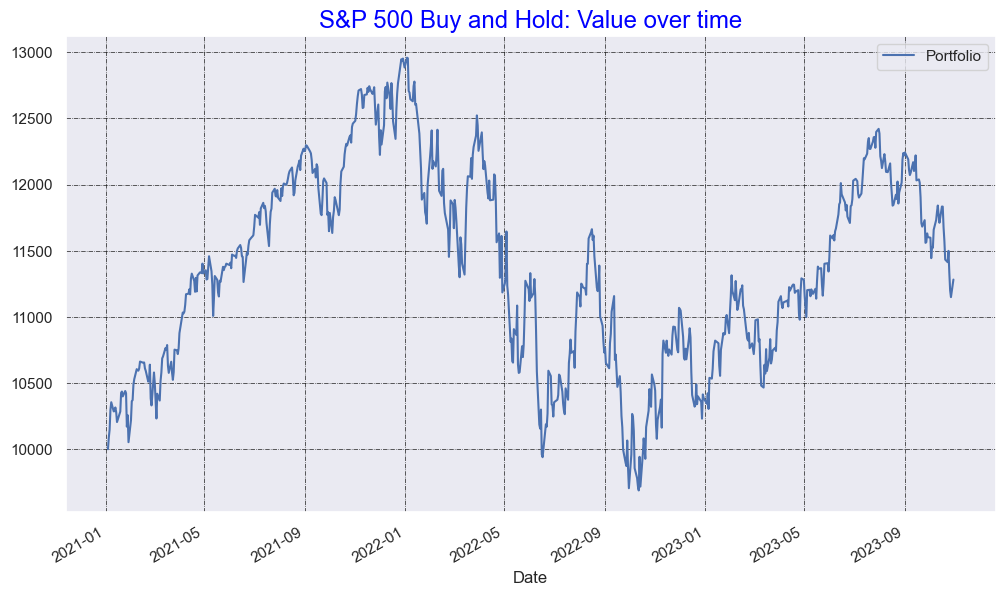

In [20]:


# Load SPY data in the same time span 
ticker = 'SPY'
startDate = '2021-01-01'
endDate = '2023-10-31'



# Initialize the trading system
trader = TradingSystem()
# Add the Apple data to the trading system
trader.AddData(ticker, startDate, endDate)
# Set the strategy of the trading system to a naive strategy
# where we buy on one day and sell on the next day
trader.SetStrategy(BuyAndHold())
# The portfolio starts with $10000 
trader.portfolio.SetInitialCash(10000)


 
 # Perform a backtest for the basic trading strategy  
trader.Run()




print('Starting Portfolio Value: %.2f' % trader.portfolio.initialCash)
print('Final Portfolio Value: %.2f' % trader.GetPortfolioValue())
# PlotStockData(ticker, (trader.datas[ticker])['Adj Close'])


# Analyze the backtest by providing various statistics
print(trader.GetStats())
spyLog = trader.log['Portfolio']

# Plot the portfolio value
trader.log[['Portfolio']].plot(figsize=(12,7))
plt.title("S&P 500 Buy and Hold: Value over time",size='x-large',color='blue')
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()


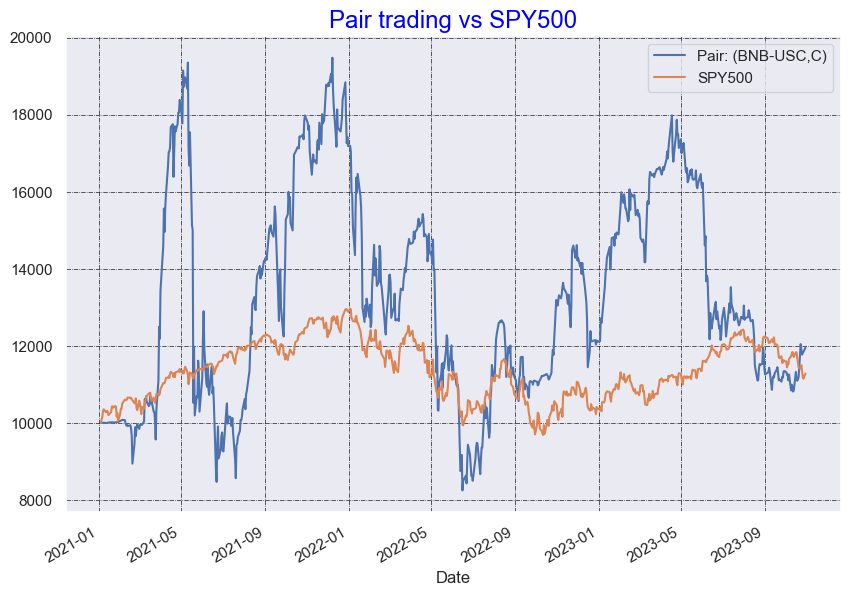

In [21]:
# Compare the pairs strategy to SPY 500

df = pd.DataFrame(index = pairLog.index)
df['Pair: (BNB-USC,C)'] = pairLog
df['SPY500'] = spyLog
df.plot(figsize=(10,7))
plt.title("Pair trading vs SPY500",size='x-large',color='blue')
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.legend()
plt.show()